# Habits Analysis (DataKnight)

Justin Witter
Aug-Sep 2023

## Goal
Provide support for beginner chess principles by using statistical methods on Chess.com games.

## Principles
1. Never Resign



In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import time
import chess.svg
import chess.engine
import chess.pgn
from tqdm import tqdm
from IPython.display import SVG, display, clear_output

In [2]:
# import data
df = pd.read_csv(r"C:\Users\witte\Downloads\clean_data.csv", index_col=0)
df = df.sample(frac=0.2,ignore_index=True)
df.head(5)

,game_id,eco,opening,white_rating,black_rating,white_result,black_result,time_class,time_control,opening_pgn,pgn,white_bracket,black_bracket
0,85752083089,A21,English,1055,1410,checkmated,win,rapid,600,1 c4 e5 2 Nc3,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",1000,1400
1,85378892119,B22,"Sicilian, Alapin",1093,912,win,checkmated,blitz,300,1 e4 c5 2 c3,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",1000,900
2,85090365933,B06,Robatsch,647,686,resigned,win,rapid,1800,1 e4 g6,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,600
3,85410769937,B00,Uncommon King's Pawn Opening,1062,1075,win,timeout,rapid,600,1 e4,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",1000,1000
4,81506219626,B20,Sicilian,693,667,win,checkmated,rapid,600,1 e4 c5,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,600


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   game_id        1957 non-null   int64 
 1   eco            1957 non-null   object
 2   opening        1957 non-null   object
 3   white_rating   1957 non-null   int64 
 4   black_rating   1957 non-null   int64 
 5   white_result   1957 non-null   object
 6   black_result   1957 non-null   object
 7   time_class     1957 non-null   object
 8   time_control   1957 non-null   object
 9   opening_pgn    1957 non-null   object
 10  pgn            1957 non-null   object
 11  white_bracket  1957 non-null   int64 
 12  black_bracket  1957 non-null   int64 
dtypes: int64(5), object(8)
memory usage: 198.9+ KB


### Principle 1 - *Never Resign*

This first principle suggests that, because of the wide variance in move quality at a low level, you should always stick it out and try for a win.

We'll be using centipawn score to determine who has advantage in a given position and see how many times that advantage switches in a game

In [4]:
# Is there more variation in eval for lower rated games?
# Are lower rated players more likely to resign?
# At what eval are these players resigning?

In [5]:
stockfish_path = r"C:\Users\witte\Downloads\stockfish"
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

total_switches = []
total_moves = []
for pgn in tqdm(df['pgn'], desc='Evaluating games'):
    pgn = io.StringIO(pgn)
    game = chess.pgn.read_game(pgn)
    board = game.board()
    
    eval_time = 10**(-10)
    prev_eval = 0
    switches = 0
    moves = 0
    for move in game.mainline_moves():
        moves+=1
        current_eval = engine.analyse(board, chess.engine.Limit(time=eval_time))['score'].white().score(mate_score=100000)
        if np.sign(prev_eval) != np.sign(current_eval):
            switches += 1
        prev_eval = current_eval
        board.push(move)
        
    total_switches.append(switches)
    total_moves.append(moves)

Evaluating games: 100%|██████████| 1957/1957 [04:36<00:00,  7.07it/s]


In [6]:
df['switches'] = total_switches
df['moves'] = total_moves

In [29]:
# remove brackets with few players
good = list(df['white_bracket'].value_counts()[df['white_bracket'].value_counts() > 100].index)
df = df[df['white_bracket'].isin(good) & df['black_bracket'].isin(good)]
# df['white_bracket'] = df['white_bracket'].cat.remove_unused_categories()

In [30]:
df['black_bracket'].value_counts()

1000    206
900     170
700     170
800     162
600     146
1100    124
1200    121
500     102
1300     68
Name: black_bracket, dtype: int64

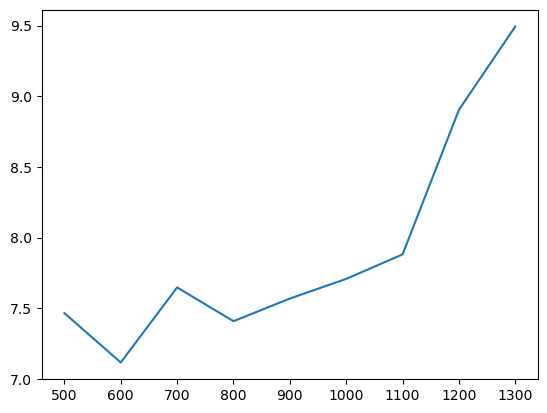

In [31]:
plt.plot(df.groupby('white_bracket')['switches'].mean())

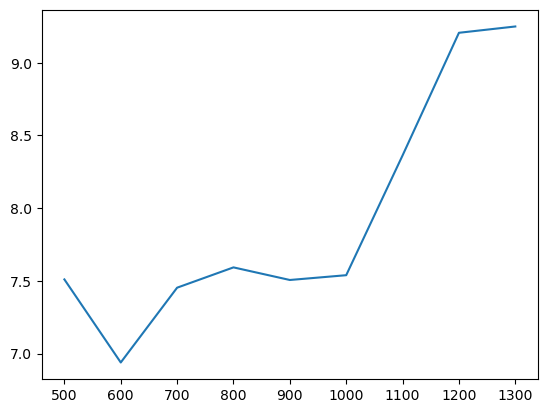

In [32]:
plt.plot(df.groupby('black_bracket')['switches'].mean())

There seems to be more switches in higher elo ranges, but if we assume that low elo players already resign earlier than they should, this could be expected. Let's see how many moves are played per switch.

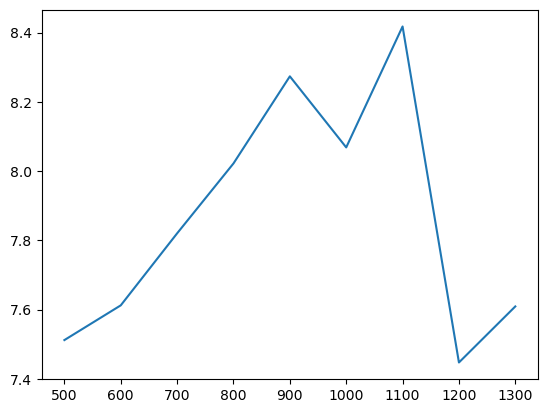

In [33]:
plt.plot(df.groupby('black_bracket')['moves'].mean()/df.groupby('black_bracket')['switches'].mean())

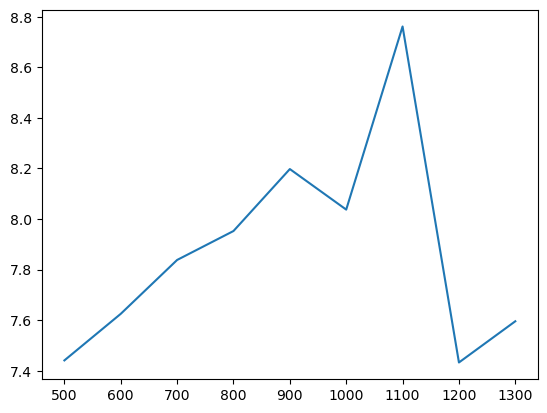

In [34]:
plt.plot(df.groupby('white_bracket')['moves'].mean()/df.groupby('white_bracket')['switches'].mean())

While there are more switches in higher elo games, the switches are occurring faster in lower elo games which may provide support for the principle of never resigning.